In [16]:
import yfinance as yf
import pandas as pd
import numpy as np
from fredapi import Fred
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Set your FRED API key
FRED_API_KEY = "6756ed768a16a2294deda4a4632615c8"
fred = Fred(api_key=FRED_API_KEY)
# Define the date range (last 5 years)
end_date = datetime.today()
start_date1 = end_date - timedelta(days=5*365)
start_date2 = end_date - timedelta(days=365)

# --- Helper Functions for FRED -Series ---
def get_fred_series(ticker,start_date=start_date2):
    """Attempt to fetch a series from FRED and return an empty Series on failure."""
    try:
        series = fred.get_series(ticker)
        # Ensure a DatetimeIndex
        if not isinstance(series.index, pd.DatetimeIndex):
            series.index = pd.to_datetime(series.index)
        series = series.loc[start_date:end_date]  # Limit to last 5 years
        return series
    except Exception as e:
        print(f"Error fetching FRED series '{ticker}': {e}")
        return pd.Series(dtype=float)

def get_last(series):
    """Return the last value of a pandas Series, or np.nan if empty or error."""
    try:
        return series.iloc[-1] if not series.empty else np.nan
    except Exception:
        return np.nan


In [ ]:
# --- Data Fetching Functions ---
# 1. Yield Data – EFFR / 2Y / 10Y / 20Y
def fetch_yields():
    tickers = {"EFFR": "DFF", "2Y": "DGS2", "10Y": "DGS10", "20Y": "DGS20"}
    return {name: get_fred_series(ticker,start_date1) for name, ticker in tickers.items()}

# 2. 2s10s Spread (calculated from full yield series)
def fetch_2s10s_spread():
    series_2Y = get_fred_series("DGS2")
    series_10Y = get_fred_series("DGS10")
    # Subtract series; pandas will align by index automatically.
    spread = series_10Y - series_2Y
    return spread

# 3. Inflation Expectations (TIPS vs Michigan)
def fetch_inflation_expectations():
    tips_breakeven = get_fred_series("T10YIE",start_date1)
    michigan_expectations = get_fred_series("MICH",start_date1)
    return {"TIPS": tips_breakeven, "Michigan": michigan_expectations}

# 4. Unemployment & CPI (Expected vs Real)
def fetch_unemployment_cpi():
    unemployment = get_fred_series("UNRATE",start_date1)
    cpi_series = get_fred_series("CPIAUCSL",start_date1)
    cpi_pct_change = cpi_series.pct_change() * 100  # percentage change
    return {"Unemployment": unemployment, "CPI (MoM % Change)": cpi_pct_change}

# 5. FRED Data (R*, Balance Sheet)
def fetch_rstar():
    r_star = get_fred_series("NROU",start_date1)
    return r_star

def fetch_balance_sheet():
    balance_sheet = get_fred_series("WALCL",start_date1)
    return balance_sheet

# 6. Volatility, Commodities, International Markets
def fetch_volatility_commodities():
    # Volatilities from FRED
    volatilities = {
        "VIX": get_fred_series("VIXCLS"),
        "GoldVIX": get_fred_series("GVZCLS"),
        "OilVIX": get_fred_series("OVXCLS")
    }
    # Commodities & international indices from Yahoo Finance (full history)
    commodities = {}
    tickers = ["CL=F", "GC=F", "^NSEI", "^HSI"]
    for ticker in tickers:
        try:
            history = yf.Ticker(ticker).history(start=start_date2, end=end_date)["Close"]
            # Ensure the index is datetime
            if not history.empty and not isinstance(history.index, pd.DatetimeIndex):
                history.index = pd.to_datetime(history.index)
            commodities[ticker] = history
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")
            commodities[ticker] = pd.Series(dtype=float)
    return {"volatilities": volatilities, "commodities": commodities}

# 7. PE Ratios (Schiller PE) – not implemented
def fetch_pe_ratios():
    return None

# 8. Home Price Index
def fetch_home_price_index():
    homepriceindex = get_fred_series("CSUSHPINSA",start_date1)
    return {"Home Price Index": homepriceindex}

# 9. Currencies – DXY (US Dollar Index) from Yahoo Finance
def fetch_currency_indices():
    try:
        dxy_series = yf.Ticker("DX-Y.NYB").history(start=start_date2, end=end_date)["Close"]
        if not dxy_series.empty and not isinstance(dxy_series.index, pd.DatetimeIndex):
            dxy_series.index = pd.to_datetime(dxy_series.index)
        return {"DXY": dxy_series}
    except Exception as e:
        print(f"Error fetching DXY data: {e}")
        return {"DXY": pd.Series(dtype=float)}

# 10. Multi-Asset Correlation Matrix (kept as in original)
def fetch_correlation_matrix():
    assets = ["SPY", "IEF", "GLD", "BTC-USD", "DX-Y.NYB"]
    price_data = {}
    for ticker in assets:
        try:
            history = yf.Ticker(ticker).history(period="6mo")["Close"]
            if not history.empty:
                price_data[ticker] = history
        except Exception as e:
            print(f"Error fetching history for {ticker}: {e}")
            continue

    if not price_data:
        print("No price data available for correlation matrix.")
        return None

    # Align the data by concatenating on the index and computing percent changes
    df = pd.concat(price_data, axis=1)
    df = df.pct_change().dropna()

    if not df.empty:
        correlation_matrix = df.corr()
        plt.figure(figsize=(10, 6))
        sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
        plt.title("Multi-Asset Correlation Matrix")
        plt.show()
        return correlation_matrix
    else:
        print("Not enough data after computing percent changes.")
        return None

# 11. Credit Spreads (BofA IG, HY)
def fetch_credit_spreads():
    spreads = {
        "BofA IG": "BAMLC0A4CBBBEY",
        "BofA HY": "BAMLH0A0HYM2EY",
    }
    return {key: get_fred_series(value) for key, value in spreads.items()}

# 12. Net Lending
def fetch_net_lending():
    return get_fred_series("W996RC1Q027SBEA",start_date1)

In [18]:
# --- Plotting Helper Functions ---

def plot_series_with_zscore(series, title, ylabel):
    """
    Plot a time series with dual y-axes:
      - Left y-axis: the original (absolute) values.
      - Right y-axis: the z-scores (computed using the overall mean and std of the series)
    
    In the z-score plot, the area between the z-score line and zero is filled with colors:
      - Red for areas where z-score is ≥ 2 or ≤ -2 (indicating out-of-ordinary values)
      - Green for values between -2 and 2 (considered normal)
    
    Parameters:
      series: A pandas Series with a datetime index.
      title:  The title for the plot.
      ylabel: The label for the left y-axis (original values).
    """
    if series.empty:
        print(f"No data to plot for {title}")
        return

    # Create figure and dual y-axes
    fig, ax1 = plt.subplots(figsize=(12,6))
    ax2 = ax1.twinx()

    # Plot the original series on the left y-axis
    ax1.plot(series.index, series, label='Value', color='blue')
    ax1.set_ylabel(ylabel, color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Compute overall mean and standard deviation for the series
    mean_val = series.mean()
    std_val = series.std()

    # Compute z-scores for each point in the series
    zscore = (series - mean_val) / std_val

    # Plot the z-score series on the right y-axis
    ax2.plot(series.index, zscore, label='Z-Score', color='green')
    ax2.axhline(0, color='black', linestyle='--', linewidth=0.8, label='Mean (0)')
    ax2.set_ylabel("Z-Score", color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    # Define masks for different z-score regions
    mask_high = zscore >= 2
    mask_low = zscore <= -2
    mask_normal = (zscore > -2) & (zscore < 2)

    # Fill areas on the z-score plot:
    # - Red when z-score is above 2 or below -2 (out-of-ordinary)
    # - Green for values between -2 and 2 (normal range)
    ax2.fill_between(series.index, zscore, 0, where=mask_high,
                     facecolor='red', alpha=0.3, interpolate=True, label='> 2 SD')
    ax2.fill_between(series.index, zscore, 0, where=mask_low,
                     facecolor='red', alpha=0.3, interpolate=True, label='< -2 SD')
    ax2.fill_between(series.index, zscore, 0, where=mask_normal,
                     facecolor='green', alpha=0.3, interpolate=True, label='Normal (-2,2)')

    # Set the plot title
    plt.title(title)

    # Combine legends from both axes
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

    plt.show()


def plot_zscore_series(series_dict, title, ylabel="Z-Score"):
    """
    Plot multiple z-score time series on a single graph with background bands marking different risk levels.
    
    Improvements:
      - Light green band for standard deviation range (-1 to 1) -> Safe Zone.
      - Yellow band for (-2 to -1) and (1 to 2) -> Caution Zone.
      - Red band for extreme values (below -2 and above 2) -> High Risk.
      - Dashed horizontal lines marking each standard deviation level.
    
    Parameters:
      series_dict: Dictionary where keys are series names and values are pandas Series with a datetime index.
      title:       The title for the plot.
      ylabel:      Label for the y-axis (default "Z-Score").
    """
    if not series_dict:
        print("No data provided to plot.")
        return

    fig, ax = plt.subplots(figsize=(12,6))
    
    # Compute z-scores for each series and track min/max values to set y-limits
    zscores = {}
    global_z_min = float('inf')
    global_z_max = float('-inf')
    
    for name, series in series_dict.items():
        if series.empty:
            print(f"No data to plot for {name}")
            continue
        
        mean_val = series.mean()
        std_val = series.std()
        zscore = (series - mean_val) / std_val
        zscores[name] = (series.index, zscore)
        global_z_min = min(global_z_min, zscore.min())
        global_z_max = max(global_z_max, zscore.max())
    
    # Ensure that the plot shows at least the range [-3, 3] for better visibility
    y_min = min(global_z_min, -3)
    y_max = max(global_z_max, 3)
    ax.set_ylim(y_min, y_max)
    
    # --- Background Risk Levels ---
    ax.axhspan(-1, 1, facecolor='lightgreen', alpha=0.3, label='Safe (-1 to 1)')   # Safe zone
    ax.axhspan(-2, -1, facecolor='yellow', alpha=0.3, label='Caution (-2 to -1)')  # Caution zone
    ax.axhspan(1, 2, facecolor='yellow', alpha=0.3, label='Caution (1 to 2)')      # Caution zone
    ax.axhspan(y_min, -2, facecolor='red', alpha=0.3, label='High Risk (< -2)')    # High risk
    ax.axhspan(2, y_max, facecolor='red', alpha=0.3, label='High Risk (> 2)')      # High risk
    
    # --- Threshold Lines ---
    ax.axhline(2, color='black', linestyle='--', linewidth=0.8, label='Z = ±2')
    ax.axhline(-2, color='black', linestyle='--', linewidth=0.8)
    ax.axhline(1, color='gray', linestyle='--', linewidth=0.8, label='Z = ±1')
    ax.axhline(-1, color='gray', linestyle='--', linewidth=0.8)
    ax.axhline(0, color='black', linestyle='-', linewidth=1, label='Mean (0)')

    # --- Plot Each Z-Score Series ---
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    for i, (name, (index, zscore)) in enumerate(zscores.items()):
        color = colors[i % len(colors)]
        ax.plot(index, zscore, label=f'{name} Z-Score', linestyle='-', color=color, linewidth=1.5)

    # --- Formatting ---
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend(loc='upper left', fontsize=10, frameon=True, edgecolor='black')

    plt.show()

def plot_series_with_band(series, title, ylabel):
    """Plot a single time series with a 1-year rolling standard deviation band."""
    if series.empty:
        print(f"No data to plot for {title}")
        return
    plt.figure(figsize=(12,6))
    # Compute rolling standard deviation over a 365-day window
    rolling_std = series.rolling('365D').std()
    plt.plot(series.index, series, label='Value')
    plt.fill_between(series.index, series - rolling_std, series + rolling_std,
                     color='gray', alpha=0.3, label='1-Year SD Band')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

def plot_multiple_series_with_band(series_dict, title, ylabel):
    """Plot multiple time series on one graph each with their own 1-year rolling SD band."""
    plt.figure(figsize=(12,6))
    for label, series in series_dict.items():
        if series.empty:
            print(f"No data for {label}")
            continue
        rolling_std = series.rolling('365D').std()
        plt.plot(series.index, series, label=label)
        plt.fill_between(series.index, series - rolling_std, series + rolling_std,
                         alpha=0.2)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()


def plot_multiple_series(series_dict, title, ylabel):
    """
    Plot multiple time series and display the latest values on the right side without overlapping.

    Parameters:
      series_dict: A dictionary where keys are series names and values are pandas Series with a datetime index.
      title:       The title for the entire plot.
      ylabel:      The label for the y-axis.
    """
    plt.figure(figsize=(12,6))
    
    # Store the latest values and their y-positions for annotation
    latest_values = {}
    
    for label, series in series_dict.items():
        if series.empty:
            print(f"No data for {label}")
            continue

        plt.plot(series.index, series, label=label)
        
        # Store the latest value
        latest_values[label] = (series.index[-1], series.iloc[-1])
    
    # Plot settings
    plt.title(title)
    plt.ylabel(ylabel)
    plt.legend()
    
    # Get x-axis limits for positioning annotations
    xmin, xmax = plt.xlim()
    text_x = xmax + (xmax - xmin) * 0.02  # Slightly beyond the right edge
    
    # Extract y-values and sort them to avoid overlaps
    sorted_values = sorted(latest_values.items(), key=lambda x: x[1][1], reverse=True)
    
    # Adjust text positions to prevent overlapping
    y_positions = []
    for i, (label, (x, y)) in enumerate(sorted_values):
        # If too close to the previous label, shift it slightly
        if y_positions and abs(y - y_positions[-1]) < 0.05 * (plt.ylim()[1] - plt.ylim()[0]):
            y = y_positions[-1] - 0.05 * (plt.ylim()[1] - plt.ylim()[0])
        
        y_positions.append(y)
        
        plt.text(text_x, y, f"{label}: {y:.2f}", verticalalignment='center', fontsize=10,
                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
    
    plt.show()


In [19]:
# Fetch series data
yields = fetch_yields()  # rates from FRED
spread_2s10s = fetch_2s10s_spread()  # 2s10s spread series
inflation_expectations = fetch_inflation_expectations()
unemployment_cpi = fetch_unemployment_cpi()
r_star = fetch_rstar()
fed_bs = fetch_balance_sheet()  
vol_data = fetch_volatility_commodities()  # contains both volatilities and commodities
credit_spreads = fetch_credit_spreads()
net_lending = fetch_net_lending()
home_price_index = fetch_home_price_index()
currency_indices = fetch_currency_indices()

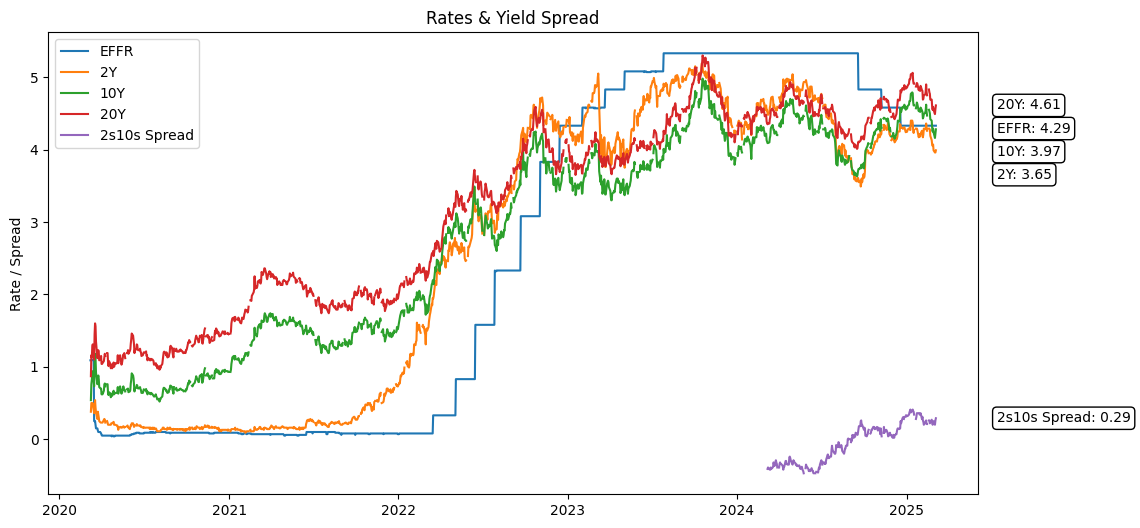

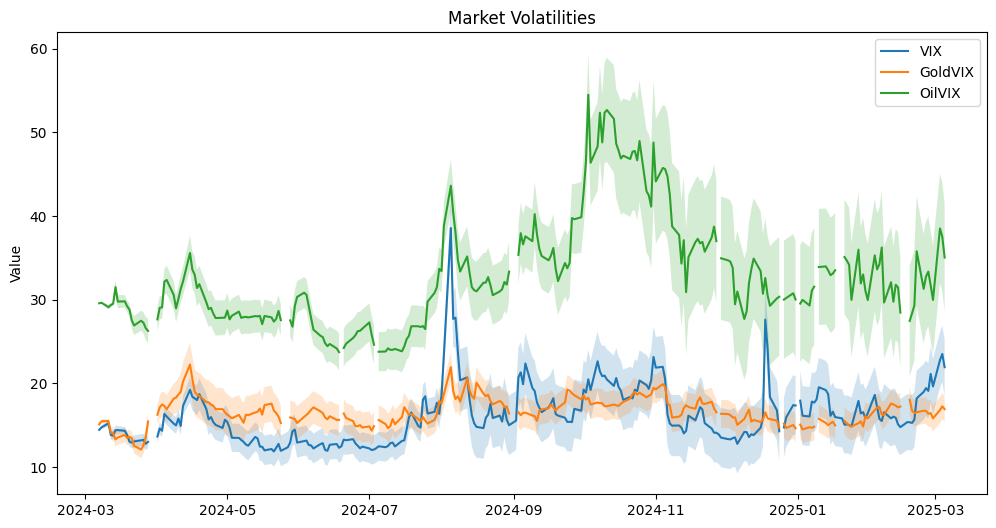

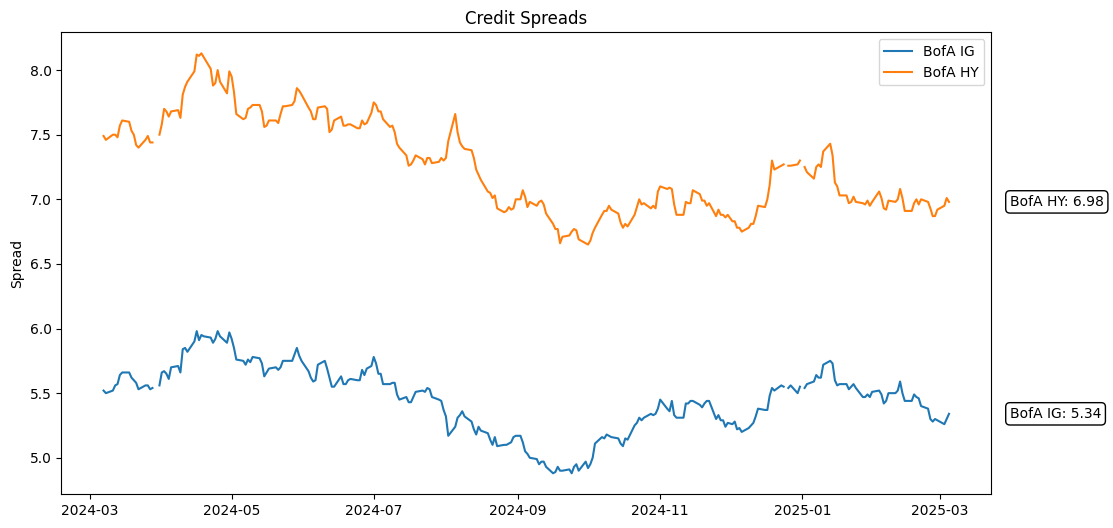

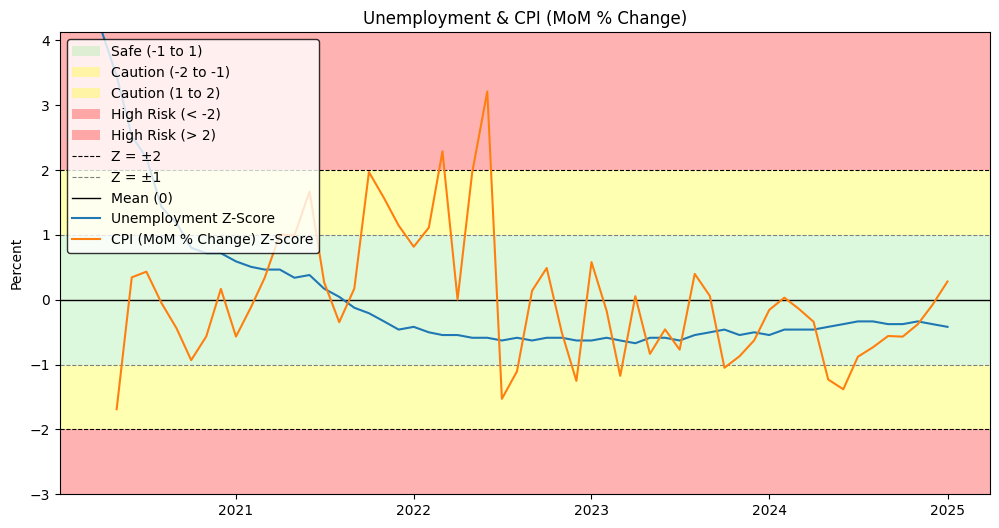

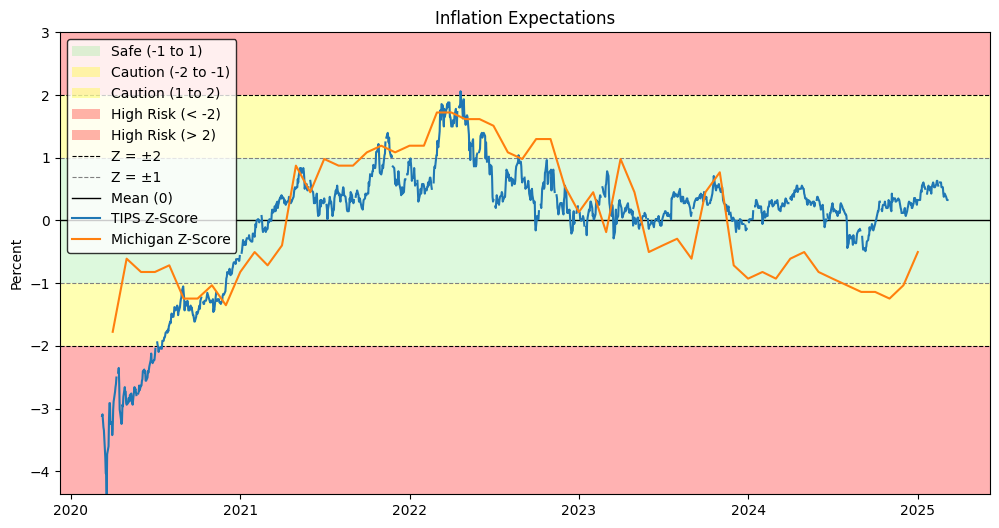

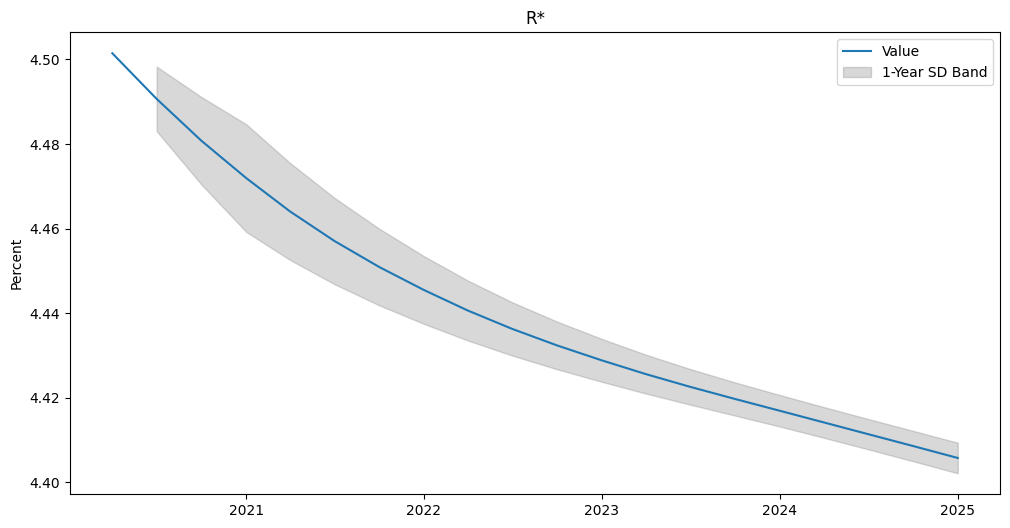

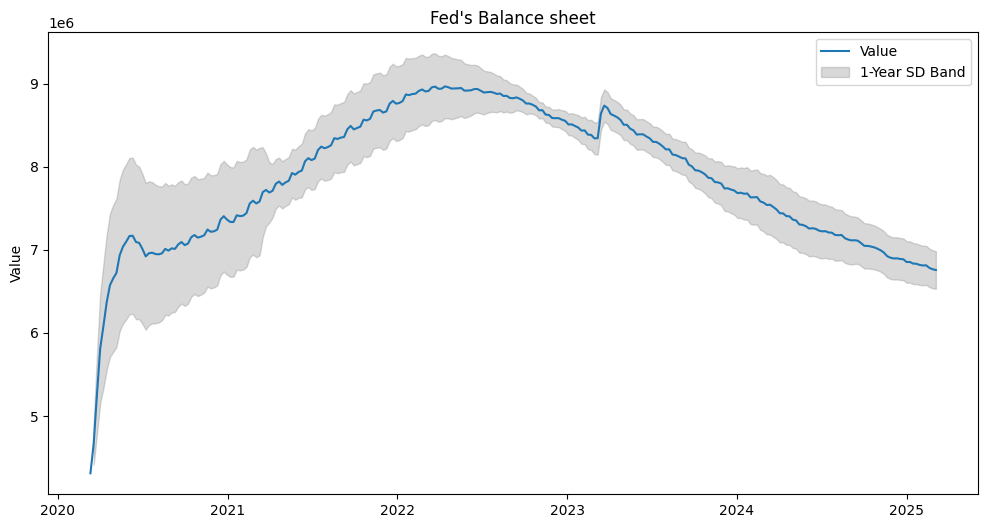

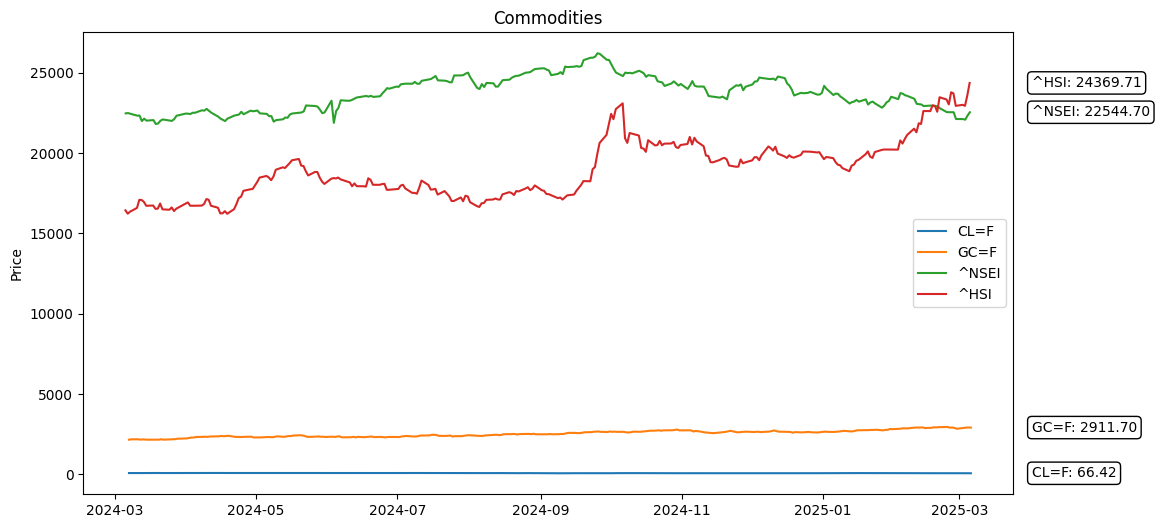

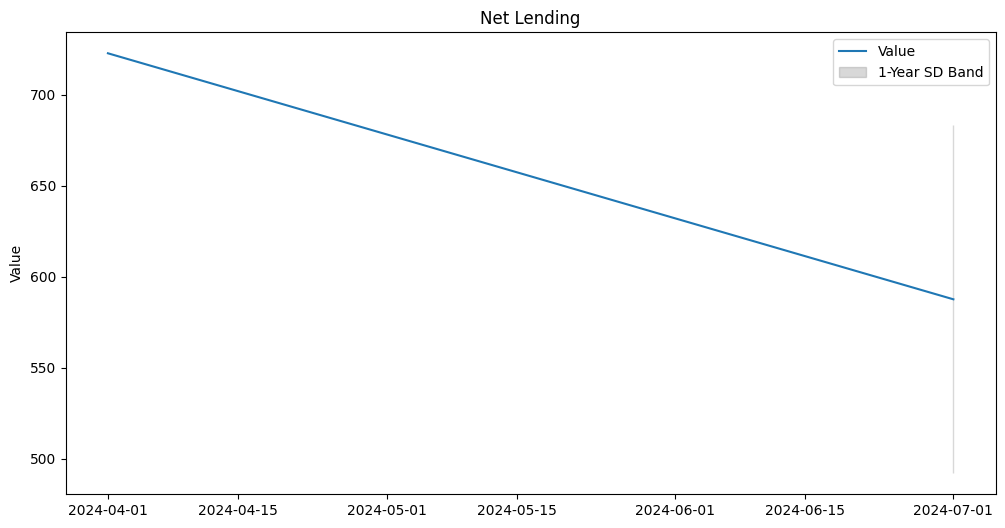

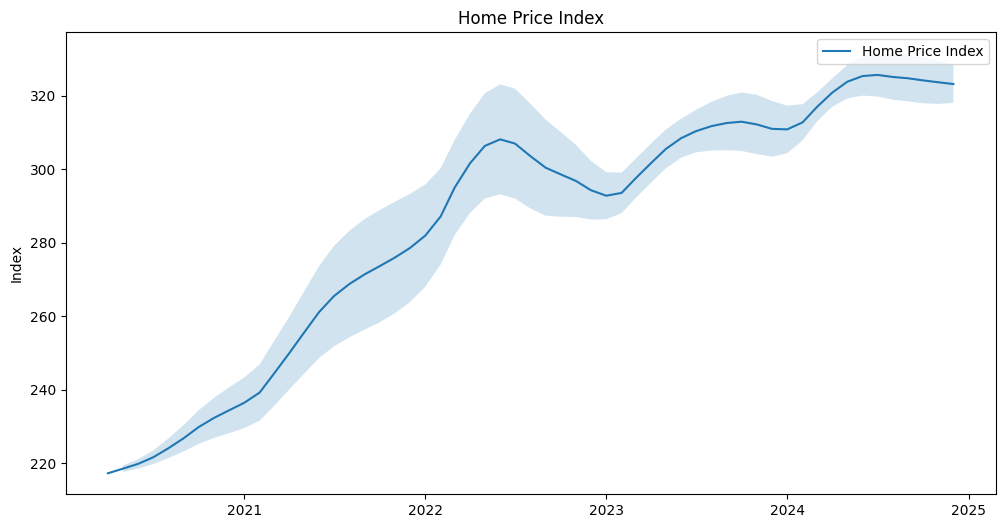

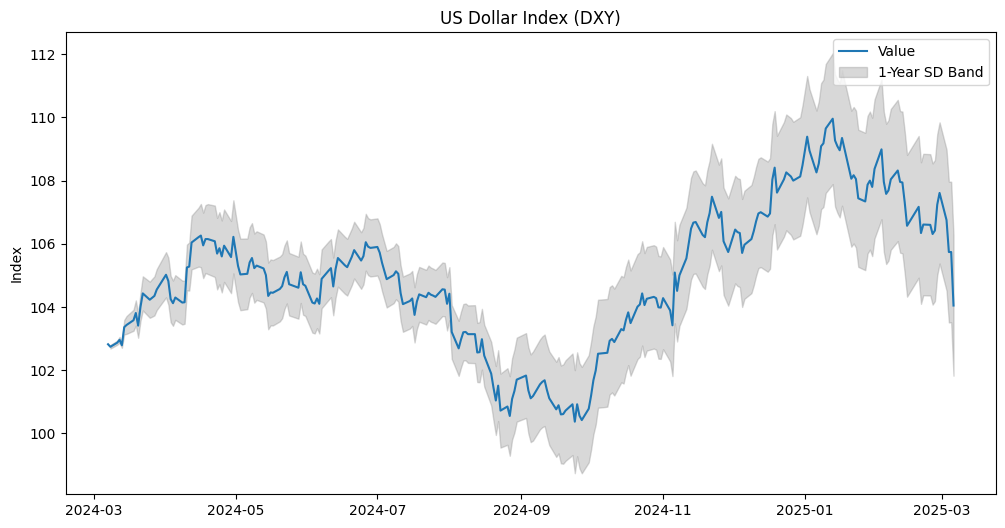

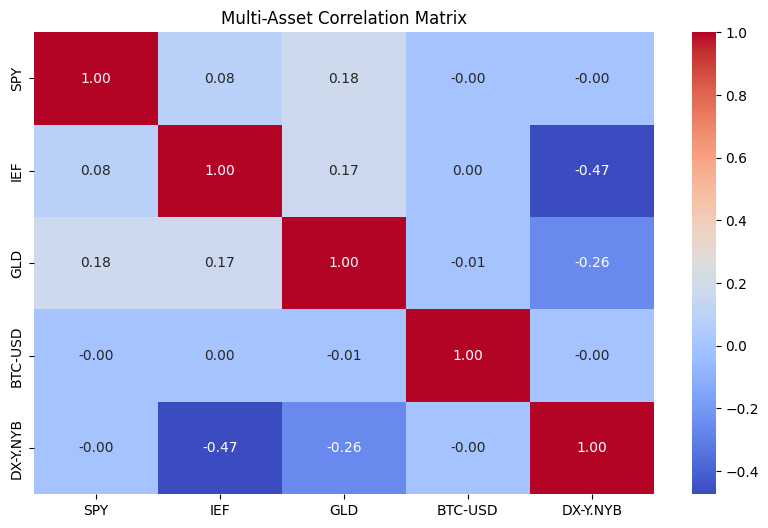

,SPY,IEF,GLD,BTC-USD,DX-Y.NYB
SPY,1.000000,0.083133,0.176649,-0.002992,-0.002518
IEF,0.083133,1.000000,0.167372,0.002432,-0.473976
GLD,0.176649,0.167372,1.000000,-0.006861,-0.255745
BTC-USD,-0.002992,0.002432,-0.006861,1.000000,-0.002377
DX-Y.NYB,-0.002518,-0.473976,-0.255745,-0.002377,1.000000


In [20]:
# ---- Grouped Plots ----
# Rates Group: yields and 2s10s spread on one graph
rates_group = yields.copy()
rates_group["2s10s Spread"] = spread_2s10s

plot_multiple_series(rates_group, "Rates & Yield Spread", "Rate / Spread")

# Volatilities Group: VIX, GoldVIX, OilVIX
plot_multiple_series_with_band(vol_data["volatilities"], "Market Volatilities", "Value")

# Credit Spreads Group
plot_multiple_series(credit_spreads, "Credit Spreads", "Spread")

# ---- Separate Plots ----
# Unemployment & CPI
plot_zscore_series(unemployment_cpi, "Unemployment & CPI (MoM % Change)", "Percent")

# Inflation Expectations
plot_zscore_series(inflation_expectations, "Inflation Expectations", "Percent")

# FRED Data (R* and Balance Sheet)
plot_series_with_band(r_star, "R*", "Percent")
plot_series_with_band(fed_bs, "Fed's Balance sheet", "Value")

# Commodities & International Markets (each separate)
plot_multiple_series(vol_data["commodities"], "Commodities", "Price")

# Net Lending
plot_series_with_band(net_lending, "Net Lending", "Value")

# Home Price Index
plot_multiple_series_with_band(home_price_index, "Home Price Index", "Index")

# Currency Indices (DXY)
dxy_series = currency_indices.get("DXY", pd.Series())
plot_series_with_band(dxy_series, "US Dollar Index (DXY)", "Index")

# Multi-Asset Correlation Matrix (as in original)
fetch_correlation_matrix()
